***Receiver Operating Characteristic (ROC) curves

A ROC curve plots the performance of a binary classifier under various threshold settings; this is measured by true positive rate and false positive rate. If your classifier predicts “true” more often, it will have more true positives (good) but also more false positives (bad). If your classifier is more conservative, predicting “true” less often, it will have fewer false positives but fewer true positives as well. The ROC curve is a graphical representation of this tradeoff.

In this mushroom dataset it is absolutely essential to correctly classify every mushroom with poisonous in order to minimize risk of get poisoned. And that means lowering the threshold even if that results in more False Positives. In other words we will focus on Recall (or Sensitivity) metric obtained from the confusion matrix.

Recall = Sensitivity = True Positive Rate = True Positives / (True Positives + False Negatives)

Here True Positives are the samples that are correctly classified as poisonous Mushrooms and the False Negatives are the mushrooms that were incorrectly classified as not poisonous. The True Positive Rate (y- axis) tells you what proportion of poisonous mushrooms samples were correctly classified. The False Positive Rate (x-axis) is the same thing as 1 - Specificity. The False Positive Rate = False Positives / False Positives + True Negatives . The False Positives are the not poisonous mushrooms that were incorrectly classified as poisonous. True Negatives are the mushrooms correctly classified as not poisonous. The False Positive Rate tells the proportion of not poisonous mushrooms that were incorrectly classified and are False Positives.

AUC (Area Under Curve)

The AUC (Area Under Curve) is the area enclosed by the ROC curve. A perfect classifier has AUC = 1 and a completely random classifier has AUC = 0.5. Usually, your model will score somewhere in between. The range of possible AUC values is [0, 1]. However, if your AUC is below 0.5, that means you can invert all the outputs of your classifier and get a better score, so you did something wrong.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
data = pd.read_csv('./train.csv').filter(
        ['Id','cap.shape', 'cap.color', 'stalk.color.above.ring',
        'stalk.color.below.ring', 'bruises', 'population','poisonous']).set_index('Id')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6499 entries, 6573 to 373
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   cap.shape               6499 non-null   object
 1   cap.color               6499 non-null   object
 2   stalk.color.above.ring  6499 non-null   object
 3   stalk.color.below.ring  6499 non-null   object
 4   bruises                 6499 non-null   bool  
 5   population              6499 non-null   object
 6   poisonous               6499 non-null   int64 
dtypes: bool(1), int64(1), object(5)
memory usage: 361.8+ KB


In [3]:
data.duplicated().sum() / data.shape[0]

0.9390675488536698

In [4]:
data.drop_duplicates(inplace=True)

In [5]:
data_test = pd.read_csv('./test.csv')

In [6]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1625 entries, 0 to 1624
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      1625 non-null   int64 
 1   cap.shape               1625 non-null   object
 2   cap.color               1625 non-null   object
 3   stalk.color.above.ring  1625 non-null   object
 4   stalk.color.below.ring  1625 non-null   object
 5   bruises                 1625 non-null   bool  
 6   population              1625 non-null   object
dtypes: bool(1), int64(1), object(5)
memory usage: 77.9+ KB


In [7]:
data_test

,Id,cap.shape,cap.color,stalk.color.above.ring,stalk.color.below.ring,bruises,population
0,5165,f,w,w,w,True,v
1,4281,f,g,n,p,False,v
2,231,x,n,w,p,True,v
3,3890,f,n,w,w,False,s
4,1521,x,y,n,p,False,v
...,...,...,...,...,...,...,...
1620,983,x,n,w,y,False,v
1621,7055,x,e,p,g,True,v
1622,7456,x,y,b,n,False,y
1623,5132,x,w,w,w,True,n


### Missing values

In [8]:
data.isna().sum()

cap.shape                 0
cap.color                 0
stalk.color.above.ring    0
stalk.color.below.ring    0
bruises                   0
population                0
poisonous                 0
dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396 entries, 6573 to 7804
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   cap.shape               396 non-null    object
 1   cap.color               396 non-null    object
 2   stalk.color.above.ring  396 non-null    object
 3   stalk.color.below.ring  396 non-null    object
 4   bruises                 396 non-null    bool  
 5   population              396 non-null    object
 6   poisonous               396 non-null    int64 
dtypes: bool(1), int64(1), object(5)
memory usage: 22.0+ KB


We can see that the dataset has values in strings.We need to convert all the unique values to integers. Thus we perform label encoding on the data.

Separating features and label

In [10]:
X = data.drop(columns=['poisonous'])
y = data['poisonous']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=8)
X_train.head()

,cap.shape,cap.color,stalk.color.above.ring,stalk.color.below.ring,bruises,population
Id,,,,,,
8008,f,g,n,b,False,y
4710,x,e,p,p,True,y
2411,f,p,w,e,True,c
7721,f,n,w,w,True,c
2250,b,n,w,y,False,v


In [11]:
cat_col= [ col for col in X_train.columns if X_train[col].dtypes == 'object']

In [12]:
categorical_pipeline = Pipeline(steps=[
    ('one-hot', OneHotEncoder(drop='first'))
])

full_processor = ColumnTransformer(transformers=[
    ('category', categorical_pipeline, cat_col)
])

Decision Tree Classifier

In [13]:
tree_pipeline = Pipeline(steps=[
    ('preprocess', full_processor), 
    ('model', DecisionTreeClassifier(max_depth=9))
])

dt_model = tree_pipeline.fit(X_train, y_train)

In [14]:
dt_preds = tree_pipeline.predict(X_test)

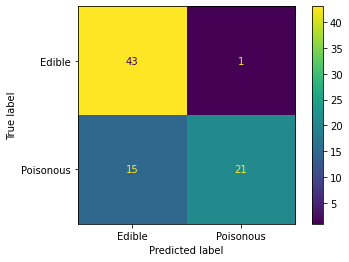

In [15]:
plot_confusion_matrix(tree_pipeline, X_test, y_test, display_labels=['Edible', 'Poisonous']);

In [16]:
dt_proba = tree_pipeline.predict_proba(X_test)

In [17]:
dt_proba = dt_proba[:,1]

In [18]:
dt_auc = roc_auc_score(y_test,dt_proba)

In [19]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, dt_proba)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8809974747474747

Text(0.5, 0, 'False Positive Rate')

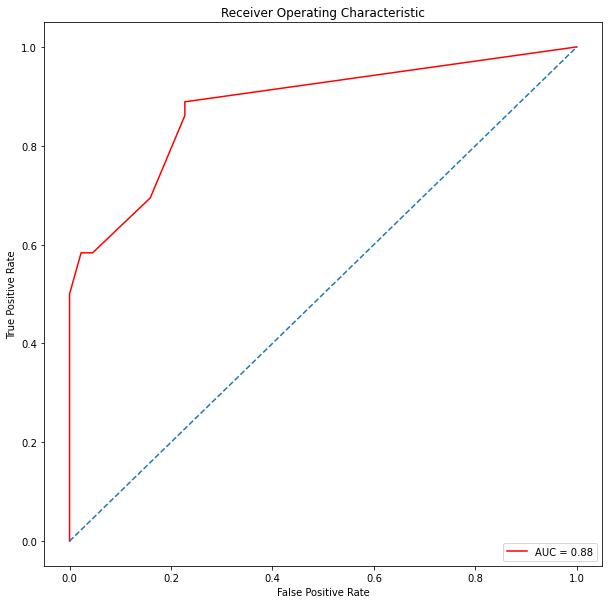

In [20]:
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Logistic Regression

In [21]:
lr_pipeline = Pipeline(steps=[
    ('processor', full_processor), 
    ('model', LogisticRegression())
])

lr = lr_pipeline.fit(X_train, y_train)

In [22]:
lr_preds = lr_pipeline.predict(X_test)

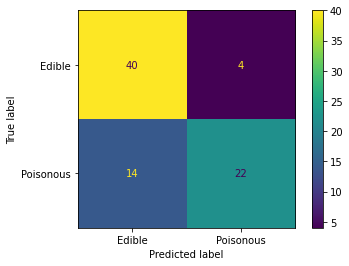

In [23]:
plot_confusion_matrix(lr_pipeline, X_test, y_test, display_labels=['Edible', 'Poisonous']);


In [24]:
lr_proba = lr_pipeline.predict_proba(X_test)

In [25]:
lr_proba = lr_proba[:,1]

In [26]:

lr_auc = roc_auc_score(y_test,lr_proba)

In [27]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, lr_proba)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9005681818181818

Text(0.5, 0, 'False Positive Rate')

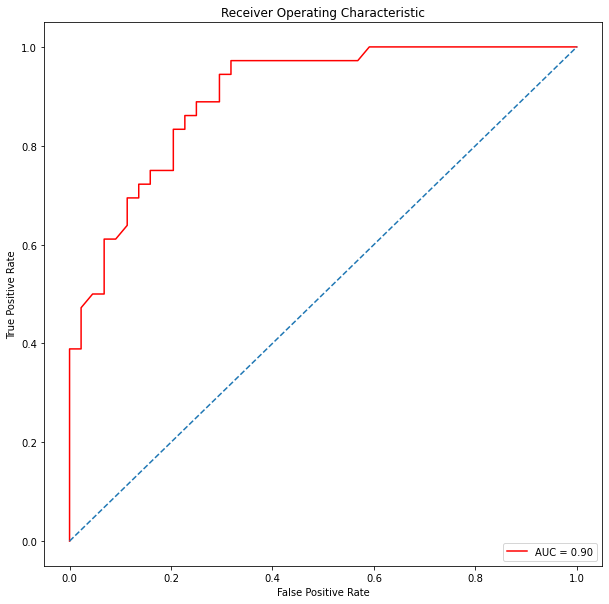

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

KNeighborsClassifier

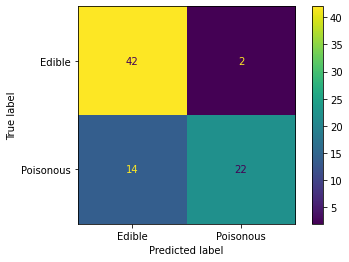

In [29]:
knn_pipeline = Pipeline(steps=[
    ('processor', full_processor), 
    ('model', KNeighborsClassifier(n_neighbors=6))
])

knn_model = knn_pipeline.fit(X_train, y_train)
knn_preds = knn_pipeline.predict(X_test)
plot_confusion_matrix(knn_pipeline, X_test, y_test, display_labels=['Edible', 'Poisonous']);

In [30]:
knn_proba = knn_pipeline.predict_proba(X_test)
knn_proba = knn_proba[:,1]
knn_auc = roc_auc_score(y_test,knn_proba)

In [31]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, knn_proba)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9179292929292929

Text(0.5, 0, 'False Positive Rate')

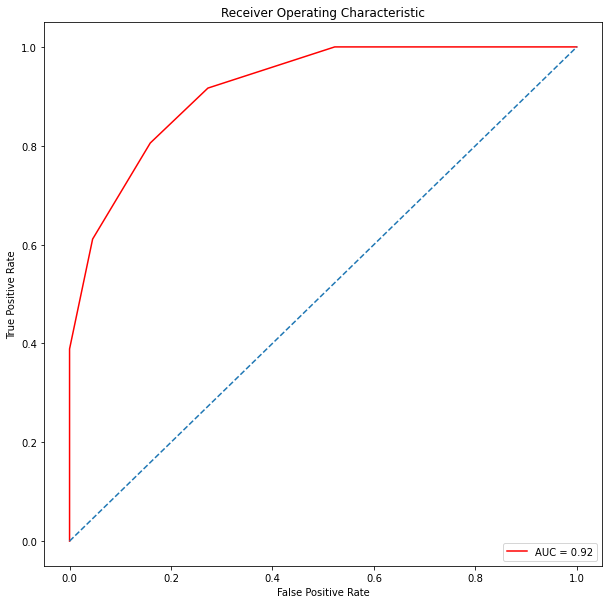

In [32]:
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Random Forest Classifier

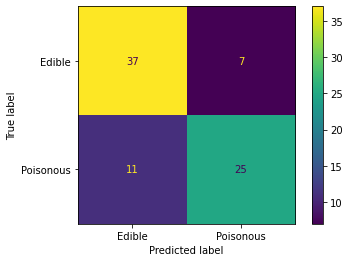

In [33]:
rf_pipeline = Pipeline(steps=[
    ('processor', full_processor), 
    ('model', RandomForestClassifier(max_features=5, n_estimators=500))
])

rf_model = rf_pipeline.fit(X_train, y_train)
rf_preds = rf_pipeline.predict(X_test)
plot_confusion_matrix(rf_pipeline, X_test, y_test, display_labels=['Edible', 'Poisonous']);

In [34]:
rf_proba = rf_pipeline.predict_proba(X_test)
rf_proba = rf_proba[:,1]
rf_auc = roc_auc_score(y_test,rf_proba)

In [35]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, knn_proba)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9179292929292929

Text(0.5, 0, 'False Positive Rate')

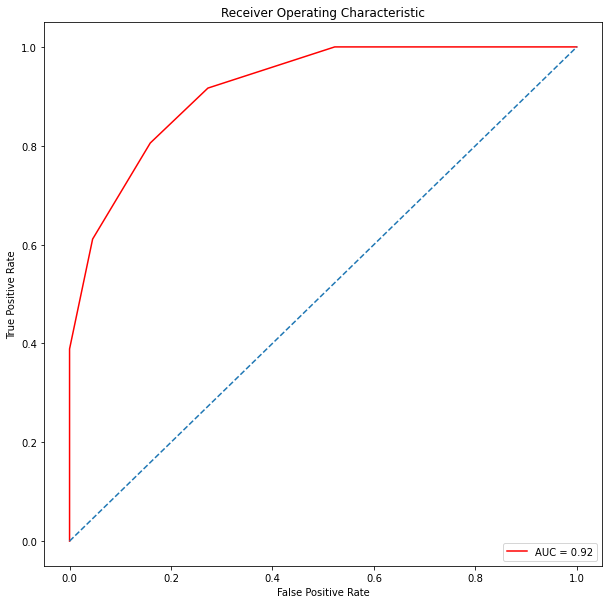

In [36]:
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
def error_metrics(y_true, y_pred, model, data): 
    print(f"""
    accuracy: {accuracy_score(y_true, y_pred)}
    roc_auc: {roc_auc_score(y_true, y_pred)}
    confusion matrix: 
    """)
    cols_names = ['edible','poisonous']
    print(
        pd.DataFrame(
            confusion_matrix(y_true, y_pred), 
            columns=cols_names, 
            index=cols_names)
        )

In [38]:
def cautious_model(poisinous_prob): 
    if poisinous_prob > 0: 
        return 1
    else: 
        return 0

def preds_review(model, data): 
    prob_df = (
        pd.DataFrame(
            model.predict_proba(data), 
            columns=['edible','poisonous']
        ))
    preds = [cautious_model(pois_prob) for pois_prob in prob_df['poisonous']]
    return preds

y_pred = preds_review(rf_pipeline, X_train)
error_metrics(y_train, y_pred, rf_pipeline, X_train)


    accuracy: 0.41139240506329117
    roc_auc: 0.5349999999999999
    confusion matrix: 
    
           edible  poisonous
edible         14        186
poisonous       0        116


In [39]:
test = pd.read_csv('./test.csv')
#results = pd.read_csv('./results.csv')
test.set_index('Id', inplace=True)

#results.drop(columns='Id', inplace=True)
#X_test_enc = ohe.transform(test)

In [40]:
sub_preds = rf_pipeline.predict(test)

submission_file = pd.DataFrame({
    'Id': data_test['Id'],
    'poisonous': sub_preds
}).to_csv('submission.csv', index=False)